# Development of a Genetic Algorithm which matches the spectral output of all LED ".txt" files in the local directory to the solar spectrum

### The spectral content of the LEDs has been measured in the Lab, while the solar spectrum is taken from a [website](https://www.pveducation.org/pvcdrom/appendices/standard-solar-spectra)

### The Genetic Algorithm desgined has been adapted from an online source which uses a genetic algorithm to solve the "travelling salesman problem" which can be found at [Traveling Salesman Problem](https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35) 

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline
from Spectral_Line_Shape import *
import os
import csv
import numpy as np
import warnings
import random
import operator
import pandas as pd
import time

Import relevant libaries

In [254]:
x_axis_total = []
y_axis_total = []

x_axis = []
solar_spectrum = []
with open("SolarSpectrum.csv") as csvfile :
    data = csv.reader(csvfile , delimiter = ',')
    
    for row in data :
        try :
            x_axis.append(float(row[0]))
            solar_spectrum.append(float(row[2]))
        except :
            pass
        
x_axis = x_axis[10:751]
solar_spectrum = solar_spectrum[10:751]

Solar Spectrum is imported as a csv and written to two local arrays. The size of the arrays have been shortened to focus on the wavelengths of interest namely 285nm - 910nm

310nm-10ms-60mA-1BC-scans1-1125-1369-ND.txt


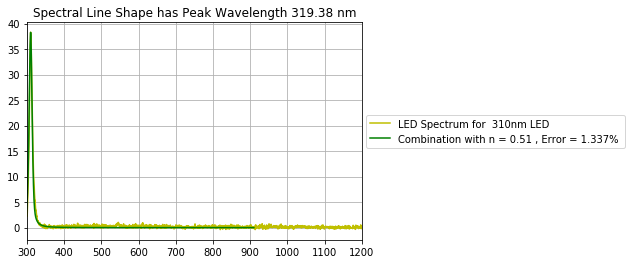

340nm-10ms-60mA-1BC-scans1-1125-1370-ND.txt


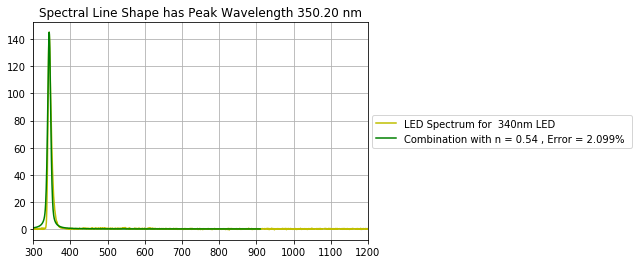

400nm-38mA-100ms-2BC-Scans3-BG-1.txt


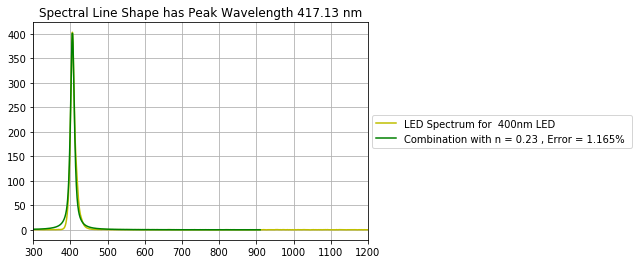

525nm-38mA-100ms-2BC-Scans3-BG-1.txt


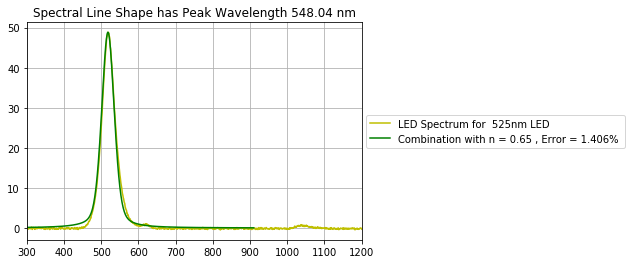

570nm-38mA-100ms-2BC-Scans3-BG-1.txt


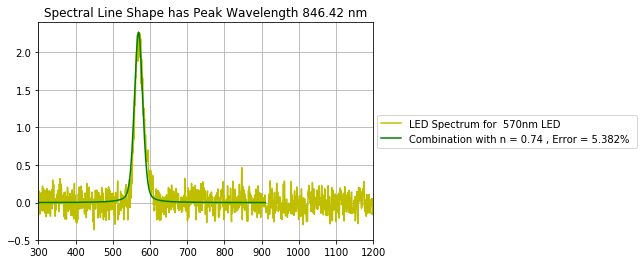

635nm-38mA-100ms-2BC-Scans3-BG-1.txt


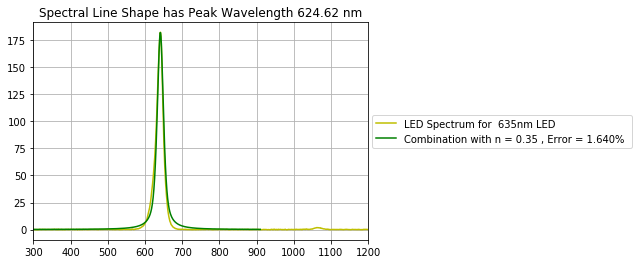

680nm-38mA-100ms-2BC-Scans3-BG-1.txt


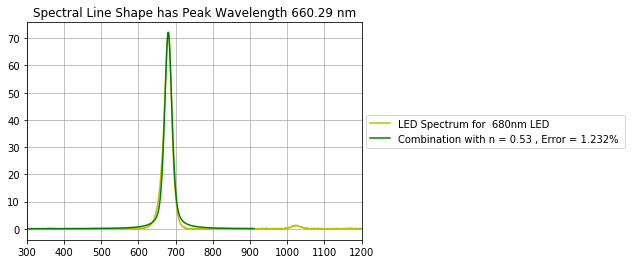

740nm-38mA-100ms-2BC-Scans3-BG-1.txt


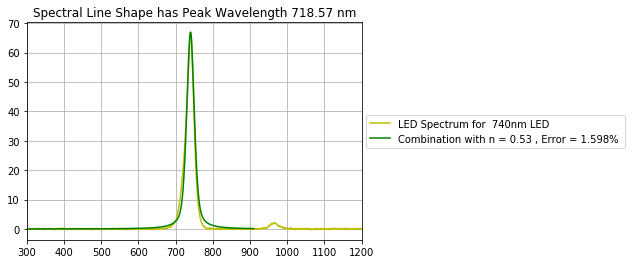

770nm-38mA-100ms-2BC-Scans3-BG-1.txt


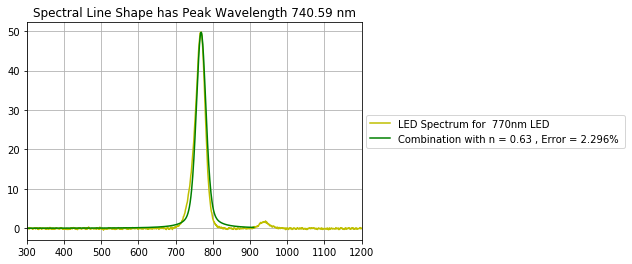

810nm-38mA-100ms-2BC-Scans3-BG-1.txt


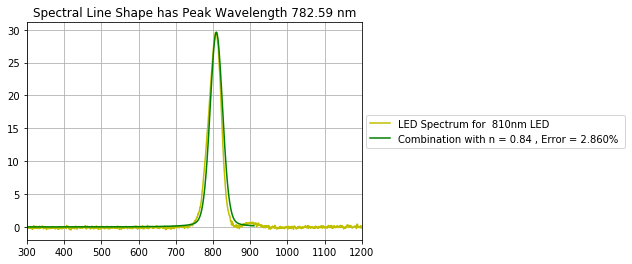

BG-10W-380-840nm-10ms-60mA-1BC-scans1.txt


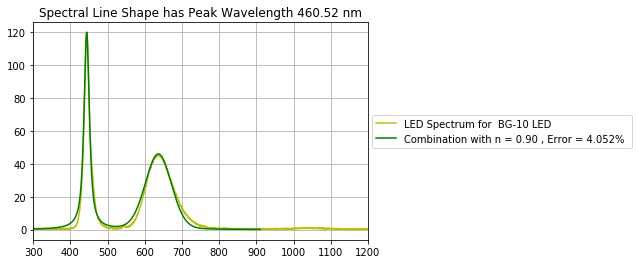

BG-10W-RG-B-10ms-60mA-1BC-scans1.txt


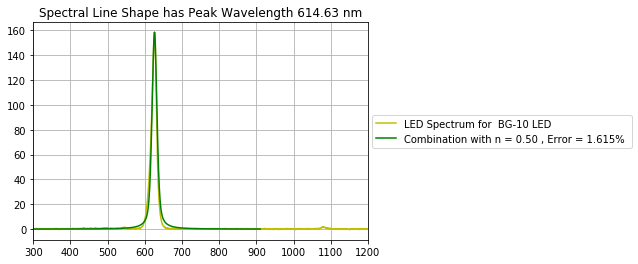

In [259]:
x_axis_total = []
y_axis_total = []

for filename in os.listdir() :
    Voigt = np.zeros(len(x_axis))
    if  filename[-3:] ==  'txt' :
        print(filename)
        count = 0
        intensity , x_axis_w = Textfile_read(filename)
        intensity_normalized = np.array(intensity)/max(intensity)
        peak = list(intensity_normalized).index(max(intensity_normalized))
        peak_value = max(intensity_normalized) 
        hightop = max(intensity)
        while peak_value > 0.22 and count < 2 :
            param , x , p_0 , w = spectral_line_fit(x_axis_w , intensity_normalized , peak)
            x_new = (p_0 - np.array(x_axis))/(w/2)
            RMSE = param[0]
            n = param[1]
            Voigt += (n*Gaussian(x_new) + (1-n)*Lorentz(x_new))*(hightop*.01)

            x_new = (p_0 - np.array(x_axis_w))/(w/2)
            intensity_new =(intensity_normalized - (n*Gaussian(x_new) + (1-n)*Lorentz(x_new)))
            peak_value = max(intensity_new)
            intensity_new = intensity_new*hightop
            intensity_normalized = np.array(intensity_new)/max(intensity_new)
            peak = list(intensity_normalized).index(max(intensity_normalized))
            hightop = max(intensity_new)
            count += 1
          
        plt.figure()
        plt.plot(x_axis_w , np.array(intensity)*.01 , 'y' , label = 'LED Spectrum for  %s LED'  % filename[:5])
        plt.plot(x_axis , Voigt , 'g' , label = 'Combination with n = %1.2f , Error = %1.3f%% ' % (n , RMSE*100))
        plt.grid()
        plt.title("Spectral Line Shape has Peak Wavelength %3.2f nm" % x_axis_w[peak])
        plt.legend(loc='lower center', bbox_to_anchor=(1.4, 0.4))
        plt.xlim(300 , 1200)
        plt.show()
        
        x_axis_total.append(x_axis)
        y_axis_total.append(Voigt)
        
x_axis_total = np.array(x_axis_total)
y_axis_total = np.array(y_axis_total)

For each LED ".txt" file in the local directory this code models the spectral content using a wegihted sum of a gaussian and a lorentz function and stores the model in the array y_axis_total. The modelling done uses the Spectral_Line_Shape module located in the Spectral Line Shaping Folder

In [137]:
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

This code performs a triangular moving average to smooth the spectral content of the sunlight. Smoothing the data removes large dips in the solar spectrum at approx 780 nm. The advantage of this is when using a RMSE there are less large overshoots.

In [257]:
solar_smooth = np.array(smoothTriangle(solar_spectrum , 40))

Performs the smoothing with the second value being the degree to whcih the spectrum is smooth

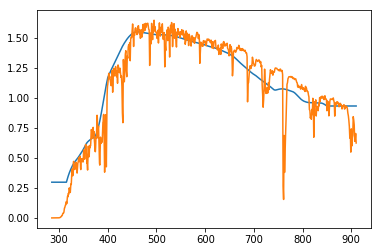

In [258]:
plt.plot(x_axis , solar_smooth)
plt.plot(x_axis , solar_spectrum)

Comparison of smooth and actual solar spectra

In [143]:
def RMSE(absError) : 
    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    
    return RMSE

Finds the Root Mean Square Error of the absolute error between the weighted sum of the spectra and the solar spectrum

In [144]:
def weighted_sum(y_axis_total , weights) :
    
    weighted_output = np.zeros(len(y_axis_total[0]))
    for i in range(len(y_axis_total)) :
        weighted_output += weights[i]*y_axis_total[i]
        
    return weighted_output

Returns the weighted sum of the LED spectra

The code below was adjusted from the webpage [towarddatascience.com](https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35) which outlines how a genetic algorithm can be used to optomize the path  of a car salesman to several cities , where he visits each city only once

In [196]:
class Params : 
    
    def __init__(self , weights) :
        self.weights = np.array(weights)
        
    def distance(self) :
        spectrum = weighted_sum(y_axis_total , self.weights)
        
        Error = abs(smooth - spectrum)
        distance = np.sum(Error)
        
        return distance
    
    def __repr__(self):
        return "(" + str(self.weights) +  ")"


Classifies the parameters over which the genetic algorithm optomizes the model. The Parameter Params.weights consists of a numpy array of float values. The position of each float value in the array corresponds to the position of the LED in the y_axis_total array

Params.distance meausres the sum of the absolute value of each element in the error array. The error array is the prediction - actual array

In [146]:
class Fitness :
    def __init__(self , spectrum) :
        self.spectrum = spectrum
        self.distance = 0
        self.fitness = 0.0     
        
    def spectrumdistance(self) :
        if self.distance == 0 :
            total_spectrum = self.spectrum
            pathdistance = total_spectrum.distance()
            
        self.distance = pathdistance
        
        return self.distance
       
    def spectrumfitness(self) :
        if self.fitness == 0 :
            self.fitness = 1 / float(self.spectrumdistance())
            
        return self.fitness

This class describes the fitness of each Param in the population. The gentic Algorithm maximizes the fittest function, hence it is the inverse of the variation described above that is taken

In [197]:
def initialPopulation(popSize):
    population = []
    
    for i in range(0, popSize):
        population_temp = []
        for item in y_axis_total :
            population_temp.append(random.uniform(0 , float(max(smooth)/max(item))))
        population.append(Params(weights = population_temp))
        
    return population

Initial population is generated based on inputted population size and the number of LEDs in the y_axis_total array. Each element in the output consists of a numpy array of weights for each LED in y_axis_total. The value of the weight is generated by the maximum intensity of the solar spectrum divided by the maximum intensity of that LED.

In [148]:
def rankParams(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).spectrumfitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Ranks the models based on their fitness values. Parameter values are stored using the Params class

In [149]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

The fittest parameters are automatically selected up to and including the length of the elitesize variable. The other values are selected randomly from the group

In [150]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

This function selects all selected parameters from the selection function.

In [151]:
def breed(parent1, parent2):
    parent1 = list(parent1.weights)
    parent2 = list(parent2.weights)
    child = []
    childP1 = []
    childP2 = []
    childP3 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
        
    child = parent1[:startGene] + parent2[startGene:endGene] + parent1[endGene:]
    
    return Params(weights = child)

Crossover is achieved by combining two arrays of weights. This is known as ordered crossover whereby a subset of the first parent is randomly selected and then fill the remainder of the route with the genes from the second parent in the order in which they appear as per ![Crossover Image](Crossover.jpeg)

In [152]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

Ensures the fittest parameters are automatically selected and then performs crossover between the ith and ith+1 element starting from the fittest and ending at the length of the population minus the elitesize

In [198]:
def mutate(individual, mutationRate):

    for i in range(len(individual.weights)) :
        if(random.random() < mutationRate):
            individual.weights[i] = random.uniform(0 , float(max(smooth)/max(y_axis_total[i])))
    return individual

Introduces mutatation into the population if a sample is lower than the mutation rate

In [199]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Executes the mutate function for the entire set of the population

In [200]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankParams(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Executes the above funcitons so that they can be performed iteratively without the need for excess coding

In [201]:
def geneticAlgorithm(popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize)
    progress = []
    err = 1 / rankParams(pop)[0][1]
    progress.append(err)
    print("Initial Variance: " + str(err) + "\n")
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankParams(pop)[0][1])
        print("{:3.4}% complete".format(((i+1)/generations)*100), end="\r")
    
    Final = rankParams(pop)[0]
    print("\n")
    print("Final Variance: " + str((1 / Final[1])))
    bestprofileIndex = Final[0]
    bestprofile = pop[bestprofileIndex]
    return bestprofile , progress

Ties all the previous funcitons into one package and prints stating and finishing error as well as keeping track of the percentage completion

In [252]:
bestprofile , progress = geneticAlgorithm(popSize= 500 , eliteSize= 50 , mutationRate= 0.2 , generations= 50)

Initial Variance: 387.1231564855465

100.0% complete

Final Variance: 350.2436234493059


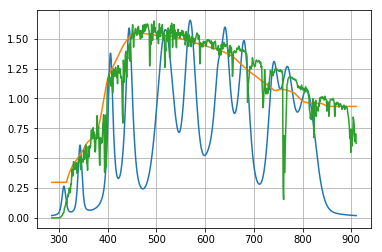

In [253]:
plt.plot(x_axis_total[0] , weighted_sum(y_axis_total , bestprofile.weights))
plt.plot(x_axis_total[0] , smooth)
plt.plot(x_axis_total[0] , solar_spectrum)
plt.grid()

Plot of model output, smoothed spectrum and actual solar sapectrum

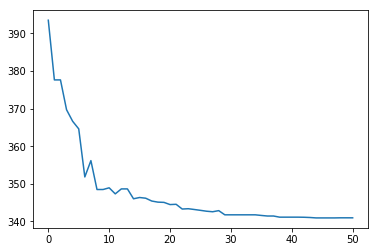

In [249]:
plt.plot(progress)

Plot of algorithm progress

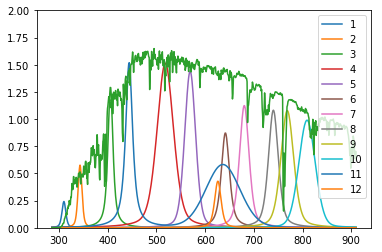

In [261]:
count = 0
for item1 , item2 in zip(y_axis_total , bestprofile.weights) :
    count += 1
    plt.plot(x_axis_total[0] , np.array(item1)*item2 , label = count)
    plt.ylim(0,2)
    
plt.legend()

    
plt.plot(x_axis_total[0] , solar_spectrum)

Plot of individual weighted outputs